# Parametric plots

When looking at Riemann problems, it is common to think about how a *wave* connects a *state* that is known to other states. For example, the Hugoniot curve gives the set of states that can be connected to a known state by a shock. Solutions to Riemann problems can be illustrated by the intersections of such curves in some parametric space.

Here we will illustrate this by showing how the curves for various problems behave in the pressure-velocity ($P-v$) space.

## Inert case

In [1]:
from r3d2 import eos_defns, State, RiemannProblem, utils
from matplotlib import pyplot
%matplotlib inline

In [2]:
gamma = 5.0/3.0
eos = eos_defns.eos_gamma_law(gamma)
test_1_U_left = State(10.0, 0.0, 0.0, 2.0, eos, label="L")
test_1_U_right = State(1.0, 0.0, 0.0, 0.5, eos, label="R")

test_1_rp = RiemannProblem(test_1_U_left, test_1_U_right)

This Riemann problem has a simple rarefaction-shock structure: a left going rarefaction, a contact, and a right going shock.

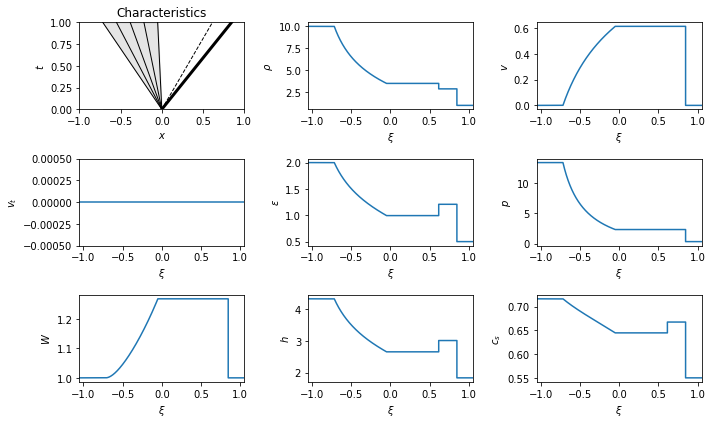

In [3]:
from IPython.display import display, display_png
display_png(test_1_rp)

The solution in parameter space shows the curves that can connect to the left and right states. Both a shock and a rarefaction can connect to either state. However, the only intersection (for the central, "star" state) is when a left going rarefaction connects to the left state, and a right going shock connects to the right state:

/home/alice/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


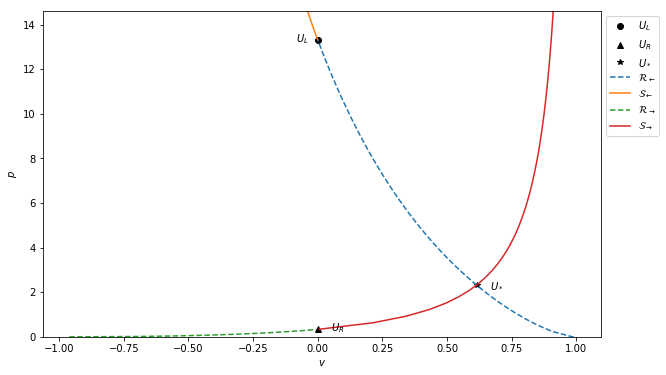

In [4]:
fig = pyplot.figure(figsize=(10,6))
ax = fig.add_subplot(111)
utils.plot_P_v(test_1_rp, ax, fig)

## Varying EOS

As noted previously, it's not necessary for the equation of state to match in the different states. Here is a problem with two inert EOSs. This problem is solved by two rarefactions.

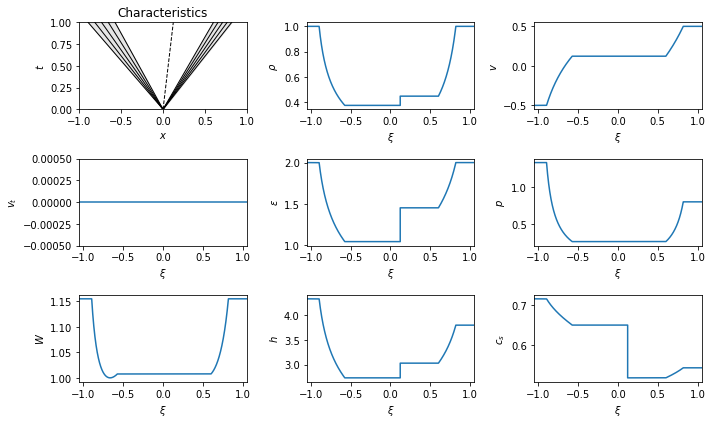

In [5]:
gamma_air = 1.4
eos_air = eos_defns.eos_gamma_law(gamma_air)
U_vary_eos_L = State(1.0, -0.5, 0.0, 2.0, eos, label="L")
U_vary_eos_R = State(1.0, +0.5, 0.0, 2.0, eos_air, label="R")
test_vary_eos_rp = RiemannProblem(U_vary_eos_L, U_vary_eos_R)
display_png(test_vary_eos_rp)

The parametric solution in this case shows the pressure decreasing across both curves along rarefactions to get to the star state:

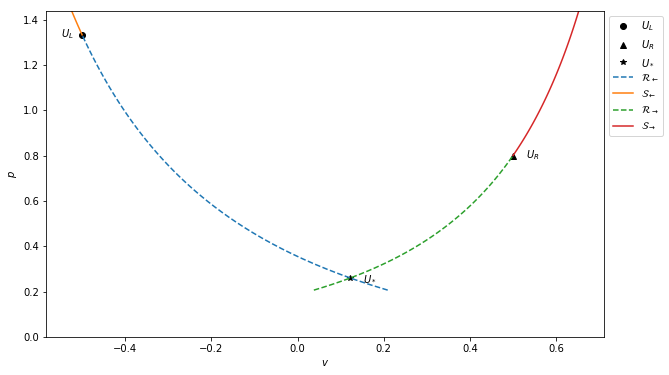

In [6]:
fig2 = pyplot.figure(figsize=(10,6))
ax2 = fig2.add_subplot(111)
utils.plot_P_v(test_vary_eos_rp, ax2, fig2)

## Reactive cases

Once reactions start, the behaviour gets more complex, and the parametric pictures can clarify some aspects. An example would be a single deflagration wave that is preceded by a shock to ignite the reaction:

/home/alice/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


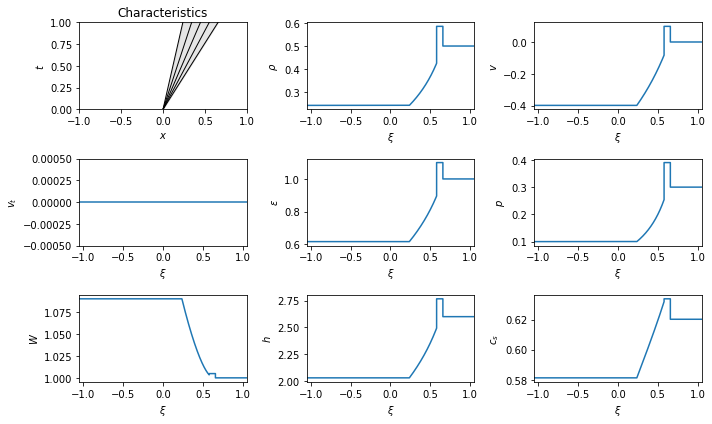

In [7]:
eos = eos_defns.eos_gamma_law(5.0/3.0)
eos_reactive = eos_defns.eos_gamma_law_react(5.0/3.0, 0.1, 1.0, 1.0, eos)
U_reactive_right = State(0.5, 0.0, 0.0, 1.0, eos_reactive)
U_reactive_left = State(0.24316548798524526, -0.39922932397353039, 0.0,
                    0.61686385086179807, eos)
test_precursor_rp = RiemannProblem(U_reactive_left, U_reactive_right)
display_png(test_precursor_rp)

The structure here looks like previous Riemann problems, but there is in fact only one wave. The right state is connected directly to the left state across a compound wave formed from a precursor shock, which raises the temperature until the gas ignites, then a Chapman-Jouget deflagration which is attached to a rarefaction.

In parameter space we see this behaviour more directly:

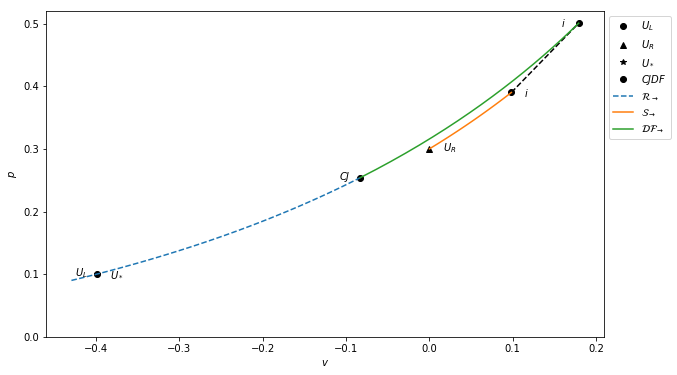

In [8]:
fig3 = pyplot.figure(figsize=(10,6))
ax3 = fig3.add_subplot(111)
utils.plot_P_v(test_precursor_rp, ax3, fig3)

The smooth joining of the deflagration and rarefaction curves at the Chapman-Jouget (CJ) point is expected, as the propagation speed of the waves must match there. The ignition point (where the temperature is high enough for the reaction to take place) is illustrated by the "$i$".